# Feature Selection

In [1]:
from config import *
ds = '36p' # Denoising Strategy:
ct = 'pearson' #Correlation Type
negative_corr = False
tm = 'gce' # Thresholding Method:
           # It could be 'GCE' or 'user_defined'
tv = 0.05  # Thresholding Value, For user defined tm

### Import

In [2]:
from src.data import subjects
import numpy as np
import pandas as pd
import glob,os
from IPython.display import display
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import collections
from src.viz import viz
import matplotlib.ticker as ticker
import src.group_level_analysis.group_level_analysis as gla
import networkx as nx

### Read Data

In [3]:
#all_sub_list = subjects.to_group_level_analysis[0]
all_sub_list = list(subjects.subjects['all']['participant_id'].values)
all_subjects = subjects.subjects['all'][subjects.subjects['all']['participant_id'].isin(all_sub_list)]

subjects_list = {}
for sg in subjects_groups:
    subjects_list[sg] = all_subjects.where(all_subjects.group==sg).dropna()
    print('\n%d %s subjects are included'%(len(subjects_list[sg]),sg))
    display(subjects_list[sg])
    subjects_list[sg] = subjects_list[sg].participant_id.tolist()


24 CN subjects are included


,group,participant_id,sex,age
0,CN,003S4288,F,78.4
1,CN,011S0021,F,84.9
2,CN,020S6185,M,82.7
3,CN,023S1190,F,87.4
4,CN,035S6160,M,60.7
5,CN,036S6189,F,69.6
6,CN,037S4028,F,70.7
7,CN,041S4200,F,76.4
8,CN,041S6159,M,76.3
9,CN,041S6192,F,83.3



24 EMCI subjects are included


,group,participant_id,sex,age
24,EMCI,012S4987,M,69.0
25,EMCI,002S4473,M,79.9
26,EMCI,011S4547,M,82.8
27,EMCI,011S4893,F,73.4
28,EMCI,012S4188,M,83.2
29,EMCI,014S2308,M,81.4
30,EMCI,037S4706,M,66.2
31,EMCI,041S4513,M,66.4
32,EMCI,041S4974,M,78.4
33,EMCI,068S2184,F,87.4



24 LMCI subjects are included


,group,participant_id,sex,age
48,LMCI,002S4171,M,69.0
49,LMCI,002S4219,F,80.0
50,LMCI,002S4229,M,66.0
51,LMCI,002S4251,M,72.0
52,LMCI,002S4654,F,75.0
53,LMCI,002S4746,F,72.0
54,LMCI,003S4354,M,81.0
55,LMCI,006S4346,M,71.0
56,LMCI,006S4363,F,74.0
57,LMCI,006S4515,M,75.0



24 AD subjects are included


,group,participant_id,sex,age
72,AD,002S5018,M,73.4
73,AD,006S4153,M,81.5
74,AD,006S4867,M,75.7
75,AD,013S5071,M,76.4
76,AD,018S4696,F,73.3
77,AD,018S4733,M,75.4
78,AD,018S5074,F,74.9
79,AD,019S4252,F,86.8
80,AD,019S4477,F,82.4
81,AD,019S4549,M,79.4


In [4]:
str_loc    = ['loc_'  + ds for ds in denoising_strategies]
str_glob   = ['glob_' + ds for ds in denoising_strategies]
strlist    = str_loc.copy()
strlist.extend(str_glob)

In [5]:
if tm=='userdefined':
    tm = '%s-%.3f'%(tm,tv)
sgn = 'positive'
if negative_corr:
    sgn = 'negative'
if ct == 'glasso':
    sgn = ''

In [6]:
norm = ""
if normalize_measures:
    norm="_norm"

directoies = {}
for ds in denoising_strategies:
    dirc = '%s/data/06_network_measures/positive/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)
    if negative_corr:
        dirc = '%s/data/06_network_measures/negative/tm-%s/corr-%s/ds-%s/'%(rootdir,tm,ct,ds)
if ct=='glasso':
    if sign=='both':
        dirc = '%s/data/06_network_measures/all/tm-/corr-%s/ds-%s/'%(rootdir,ct,ds)
    lc  = 'loc_'  + ds
    glb = 'glob_' + ds
    directoies[glb]    = glob.glob("%s/*/*global_measures_giant_component.csv"%(dirc))
    directoies[lc] = glob.glob("%s/*/*local_measures_giant_component*%s*.csv"%(dirc,norm))

In [7]:
measures = {}
measures['all'] = {}

for sg in subjects_groups: 
    measures[sg]  = {}

for i in strlist:
    measures['all'][str(i)] = {}
    for sg in subjects_groups: 
        measures[sg][str(i)]  = {}
    for sub in directoies[str(i)]:
        id = str(sub.split("/sub-")[1].split('/sub-')[0]) 
        measures['all'][str(i)][id] = pd.read_csv(sub, sep='\t')
        measures['all'][str(i)][id] = measures['all'][str(i)][id].drop(['Unnamed: 0'], axis=1)
        if 'loc' in str(i):
            measures['all'][str(i)][id] = measures['all'][str(i)][id].set_index('ID')
        for sg in subjects_groups: 

            if id in subjects_list[sg]:
                measures[sg][str(i)][id] = pd.read_csv(sub, sep='\t')
                measures[sg][str(i)][id] = measures[sg][str(i)][id].drop(['Unnamed: 0'], axis=1)
                if 'loc' in str(i):
                    measures[sg][str(i)][id] = measures[sg][str(i)][id].set_index('ID')

In [8]:
# measures variable structure:
#
#    measures
#    │
#    ├── group 1
#    │   ├── denoising strategie 1- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 1- local measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- global measures
#    │   │   └── group 1 subjects
#    │   ├── denoising strategie 2- local measures
#    │   │   └── group 1 subjects
#    │   ├── ...
#    │   │
#    │   └── denoising strategie n- local measures
#    │       └── group 1 subjects
#    │   
#    ├── ...
#    │
#    └── last group
#        ├── denoising strategie 1- global measures
#        │   └── last group subjects
#        ├── denoising strategie 1- local measures
#        │   └── last group subjects
#        ├── denoising strategie 2- global measures
#        │   └── last group subjects
#        ├── denoising strategie 2- local measures
#        │   └── last group subjects
#        ├── ...
#        │
#        └── denoising strategie n- local measures
#            └── last group subject

In [9]:
measures['all']['loc_36p']['036S4715']

,degree,eccentricity,betweenness,com_betweenness,eigenvector,katz,closeness,current_flow_closeness,load,clustering_coef,pagerank,subgraph,harmonic,strength
ID,,,,,,,,,,,,,,
0,0.163043,0.0,0.112455,0.060063,0.178214,0.390037,0.293211,0.338689,0.118192,0.417994,0.147554,0.039949,0.286996,0.323384
1,0.489130,0.0,0.382847,0.292382,0.444586,0.539179,0.476565,0.711079,0.394876,0.411983,0.494110,0.211472,0.535874,0.259601
2,0.358696,0.0,0.125797,0.264309,0.425339,0.474874,0.431183,0.592996,0.138657,0.561199,0.330322,0.194588,0.455157,0.520886
3,0.467391,0.0,0.128341,0.384916,0.532913,0.571768,0.488142,0.691641,0.131594,0.636236,0.439873,0.297926,0.533632,0.630156
4,0.510870,0.0,0.130492,0.447099,0.584686,0.502407,0.531411,0.726420,0.134923,0.657635,0.480797,0.355451,0.576233,0.619616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,0.380435,0.0,0.311768,0.046405,0.129912,0.436397,0.511582,0.608300,0.331846,0.238316,0.455847,0.023194,0.511211,0.426082
356,0.065217,0.0,0.064803,0.003505,0.022300,0.378843,0.159091,0.153837,0.076518,0.202899,0.072164,0.001716,0.152466,0.049510
357,0.402174,0.0,0.470983,0.053038,0.140955,0.685290,0.656377,0.633143,0.494920,0.145671,0.476950,0.026634,0.598655,0.461898


### Finding out nodes that exist in all networks

In [10]:
print('the number of nodes appeared in the giant components of all subjects:\n') 
intersect = {}
for i in str_loc:
    intersect[i] = list(range(360))
for i in str_loc:
    for sub in measures['all'][i]:
        a = list(measures['all'][i][sub].index)
        intersect[i] = list(set(intersect[i]) & set(a))
    name = i.split('loc_')[1]
    print('\t%d out of 360 nodes for networks with %s thresholding method.'
          %(len(intersect[i]),name))

    #removing nodes
    for sub in measures['all'][i]:
        measures['all'][str(i)][sub] = measures['all'][str(i)][sub].loc[measures['all'][str(i)][sub].index.isin(intersect[i])]

the number of nodes appeared in the giant components of all subjects:

	359 out of 360 nodes for networks with 36p thresholding method.


### Constructing Feature Matrix

It's a N*M matrix, where:

\begin{equation*}
N   =  Number \: of \: Smples; \\
M   =  (Number \: of \: Local \: Measures \: * \: Number \: of \: Nodes) \: + \: Number \: of \: Global \: Measures
\end{equation*}

In [11]:
14*359+10

5036

In [12]:
features = pd.DataFrame({})
s = []
for sub in measures['all']['loc_'+ds]:
    loc  = measures['all']['loc_'+ds][sub].stack().to_frame()
    glob = measures['all']['glob_'+ds][sub].drop(
        columns=['center', 'periphery'])
    fea  = pd.concat([loc,glob.transpose()],axis=0)
    s.append(sub)
    try:
        features = pd.concat([features,fea],axis=1)
    except NameError:
        features = fea.copy()

features.columns = s
features = features.transpose().sort_index(axis = 0)
features.index.name = 'participant_id'

In [13]:
labels = all_subjects[['group','participant_id']].sort_values(by=['participant_id'])
labels = labels.set_index('participant_id')
for g in range(len(subjects_groups)):
    labels = labels.replace(subjects_groups[g],g+1)

In [14]:
features_np = features.values
labels_np   = labels.values[:,0]

### Feature Selection Using Fisher Algorithm

In [15]:
score = fisher_score.fisher_score(features_np, labels_np)
idx   = fisher_score.feature_ranking(score)

Selecting the top 50% of features

In [16]:
fisher_features    = features.iloc[:, idx[:int(len(idx)/2)]]
fisher_features_np = fisher_features.values

Selecting effective nodes and measures based on Fisher algorithm

In [17]:
fisher_features30          = features.iloc[:, idx[:30]]
fisher_features_names30    = list(fisher_features30.T.index) 
fisher_features_names30    = [ffn for ffn in fisher_features_names30 if type(ffn)!=str]
fisher_features_nodes30    = [ffn[0] for ffn in fisher_features_names30]
fisher_features_measures30 = [ffn[1] for ffn in fisher_features_names30]
fisher_features_measures30.sort()
fisher_features_nodes30.sort()
counter_measures30=collections.Counter(fisher_features_measures30)
counter_nodes30=collections.Counter(fisher_features_nodes30)

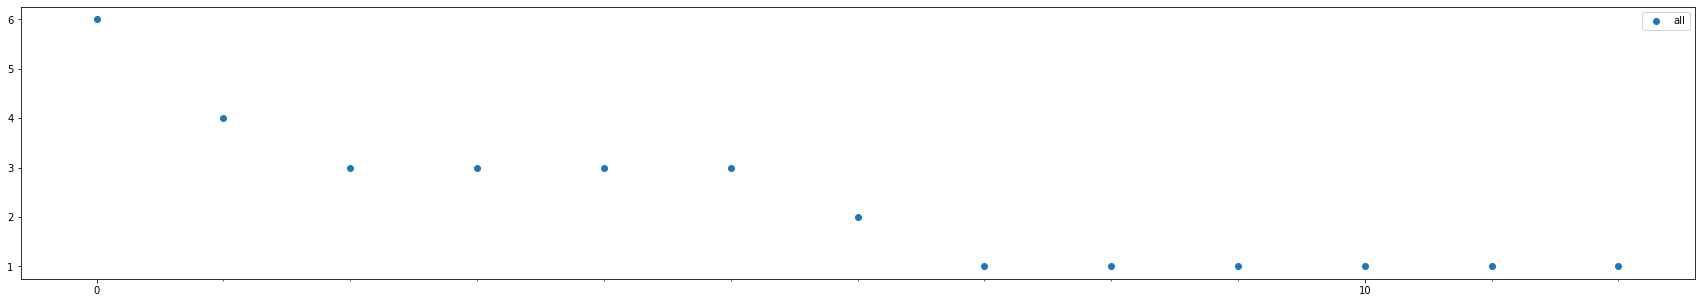

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	30 Fisher Nodes:
	[(70, 6), (345, 4), (33, 3), (165, 3), (191, 3), (250, 3), (249, 2), (69, 1), (87, 1), (163, 1), (164, 1), (171, 1), (271, 1)]


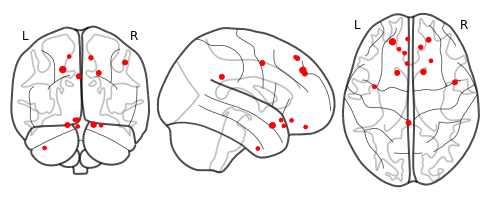

In [18]:
fig, ax = plt.subplots(figsize=(30,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes30.most_common(len(set(fisher_features_nodes30)))]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes30)), step=1))
plt.legend(['all'])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes301=counter_nodes30.most_common(30)
nd301 = [a[0] for a in fNodes301]
ns301 = [a[1] for a in fNodes301]
viz.brain_viz_nodes(nodes=nd301,
                    title=
                    "\t%s Fisher Nodes:\n\t%s"
                    %(30,counter_nodes30.most_common(30)),
                    method='2d',node_size = ns301)

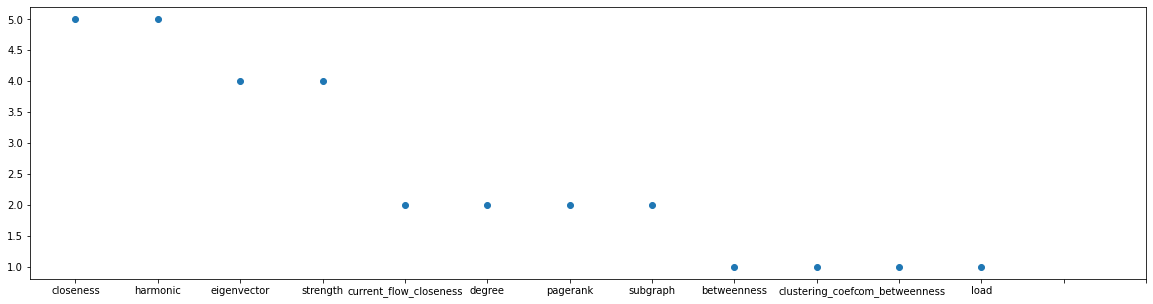

In [19]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures30.most_common(14)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()

In [20]:
print(counter_measures30.most_common(14),'\n\n',counter_nodes30.most_common(360))

[('closeness', 5), ('harmonic', 5), ('eigenvector', 4), ('strength', 4), ('current_flow_closeness', 2), ('degree', 2), ('pagerank', 2), ('subgraph', 2), ('betweenness', 1), ('clustering_coef', 1), ('com_betweenness', 1), ('load', 1)] 

 [(70, 6), (345, 4), (33, 3), (165, 3), (191, 3), (250, 3), (249, 2), (69, 1), (87, 1), (163, 1), (164, 1), (171, 1), (271, 1)]


In [23]:
fisher_features4          = features.iloc[:, idx[:int(len(idx)/4)]]
fisher_features_names4    = list(fisher_features4.T.index) 
fisher_features_names4    = [ffn for ffn in fisher_features_names4 if type(ffn)!=str]
fisher_features_nodes4    = [ffn[0] for ffn in fisher_features_names4]
fisher_features_measures4 = [ffn[1] for ffn in fisher_features_names4]
fisher_features_measures4.sort()
fisher_features_nodes4.sort()
counter_measures4=collections.Counter(fisher_features_measures4)
counter_nodes4=collections.Counter(fisher_features_nodes4)

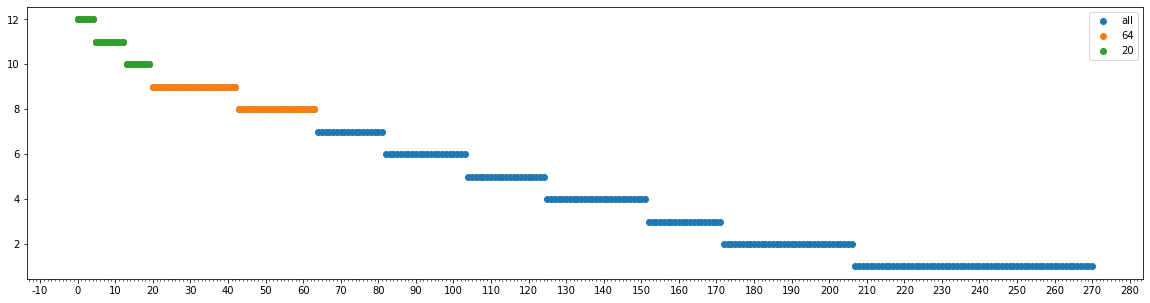

	20 Fisher Nodes:
	[(33, 12), (91, 12), (269, 12), (271, 12), (345, 12), (67, 11), (70, 11), (106, 11), (122, 11), (165, 11), (191, 11), (249, 11), (250, 11), (56, 10), (97, 10), (111, 10), (132, 10), (170, 10), (171, 10), (296, 10)]


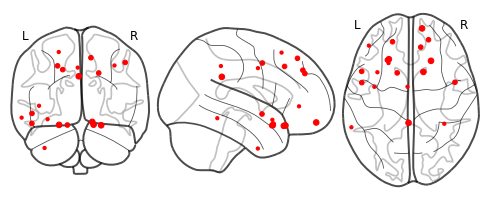

	64 Fisher Nodes:
	[(33, 12), (91, 12), (269, 12), (271, 12), (345, 12), (67, 11), (70, 11), (106, 11), (122, 11), (165, 11), (191, 11), (249, 11), (250, 11), (56, 10), (97, 10), (111, 10), (132, 10), (170, 10), (171, 10), (296, 10), (36, 9), (46, 9), (69, 9), (71, 9), (81, 9), (85, 9), (88, 9), (89, 9), (117, 9), (135, 9), (160, 9), (163, 9), (164, 9), (169, 9), (202, 9), (225, 9), (233, 9), (283, 9), (312, 9), (315, 9), (349, 9), (351, 9), (356, 9), (7, 8), (17, 8), (22, 8), (37, 8), (40, 8), (51, 8), (66, 8), (76, 8), (86, 8), (87, 8), (92, 8), (147, 8), (176, 8), (217, 8), (226, 8), (236, 8), (251, 8), (256, 8), (268, 8), (300, 8), (333, 8)]


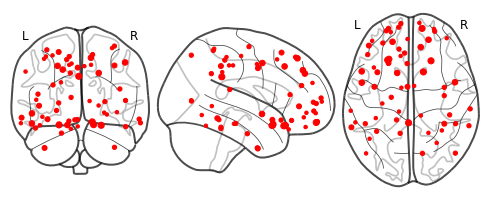

In [24]:
a1 = 64
a2 = 20
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes4.most_common(len(set(fisher_features_nodes4)))]))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes4.most_common(a1)]))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes4.most_common(a2)]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes4)), step=1))
plt.legend(['all',a1,a2])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes41=counter_nodes4.most_common(a1)
fNodes42=counter_nodes4.most_common(a2)
nd42 = [a[0] for a in fNodes42]
ns42 = [a[1] for a in fNodes42]
viz.brain_viz_nodes(nodes=nd42,title="\t%s Fisher Nodes:\n\t%s"%(a2,counter_nodes4.most_common(a2)),method='2d',node_size = ns42)
plt.show()
nd41 = [a[0] for a in fNodes41]
ns41 = [a[1] for a in fNodes41]
viz.brain_viz_nodes(nodes=nd41,title="\t%s Fisher Nodes:\n\t%s"%(a1,counter_nodes4.most_common(a1)),method='2d',node_size = ns41)
enodes4_top = [np.array(counter_nodes4.most_common(a2)),'fisher-%d'%a2]
enodes4 = [np.array(counter_nodes4.most_common(a1)),'fisher-%d'%a1]

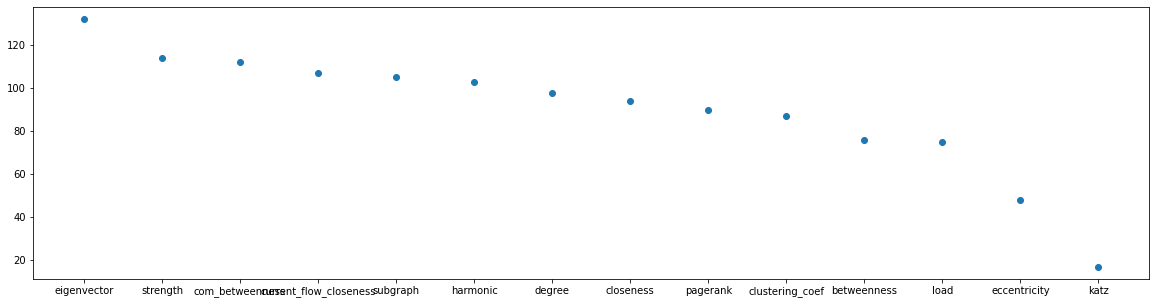

[('eigenvector', 132), ('strength', 114), ('com_betweenness', 112), ('current_flow_closeness', 107), ('subgraph', 105), ('harmonic', 103), ('degree', 98), ('closeness', 94), ('pagerank', 90), ('clustering_coef', 87), ('betweenness', 76), ('load', 75), ('eccentricity', 48), ('katz', 17)]


In [25]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures4.most_common(14)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()
print(counter_measures4.most_common(14))

### Feature Selection Using FSFS

Aplying FSFS algorithm on the first half of sorted features by the fisher score

#### classifier: LinearRegression

In [26]:
sfsLinReg = SFS(LinearRegression(),
                k_features=(35),
                forward=True,
                floating=False,
                scoring = 'r2',
                cv = 0)

In [27]:
sfsLinReg.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsLinReg.k_feature_names_

((163, 'clustering_coef'),
 (165, 'closeness'),
 (87, 'strength'),
 (355, 'clustering_coef'),
 (269, 'current_flow_closeness'),
 (211, 'load'),
 (55, 'closeness'),
 (84, 'strength'),
 (132, 'eigenvector'),
 (167, 'strength'),
 (29, 'closeness'),
 (142, 'strength'),
 (221, 'load'),
 (18, 'load'),
 (46, 'closeness'),
 (247, 'betweenness'),
 (56, 'load'),
 (301, 'clustering_coef'),
 (35, 'katz'),
 (153, 'degree'),
 (279, 'current_flow_closeness'),
 (263, 'closeness'),
 (218, 'degree'),
 (4, 'load'),
 (290, 'harmonic'),
 (11, 'strength'),
 (254, 'closeness'),
 (227, 'current_flow_closeness'),
 (41, 'eccentricity'),
 (313, 'closeness'),
 (168, 'eccentricity'),
 (9, 'com_betweenness'),
 (231, 'clustering_coef'),
 (179, 'load'),
 (10, 'strength'))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


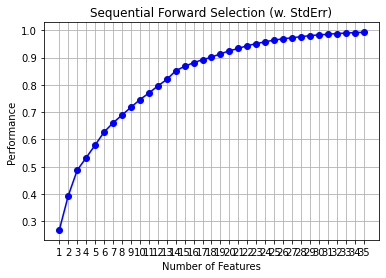

In [28]:
figLR = plot_sfs(sfsLinReg.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [29]:
sfsLinReg.get_metric_dict()

{1: {'feature_idx': (1,),
  'cv_scores': array([0.26833288]),
  'avg_score': 0.2683328816983246,
  'feature_names': ((163, 'clustering_coef'),),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 2: {'feature_idx': (1, 7),
  'cv_scores': array([0.3936903]),
  'avg_score': 0.3936903033387923,
  'feature_names': ((163, 'clustering_coef'), (165, 'closeness')),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 3: {'feature_idx': (1, 7, 226),
  'cv_scores': array([0.48706434]),
  'avg_score': 0.487064344414435,
  'feature_names': ((163, 'clustering_coef'),
   (165, 'closeness'),
   (84, 'strength')),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 4: {'feature_idx': (1, 7, 136, 226),
  'cv_scores': array([0.53308887]),
  'avg_score': 0.5330888682753321,
  'feature_names': ((163, 'clustering_coef'),
   (165, 'closeness'),
   (269, 'current_flow_closeness'),
   (84, 'strength')),
  'ci_bound': nan,
  'std_dev': 0.0,
  'std_err': nan},
 5: {'feature_idx': (1, 7, 136, 226,

In [30]:
fisher_features_names_sfsLR    = list(sfsLinReg.k_feature_names_)
fisher_features_names_sfsLR    = [ffn for ffn in fisher_features_names_sfsLR if type(ffn)!=str]
fisher_features_nodes_sfsLR    = [ffn[0] for ffn in fisher_features_names_sfsLR]
fisher_features_measures_sfsLR = [ffn[1] for ffn in fisher_features_names_sfsLR]
fisher_features_measures_sfsLR.sort()
fisher_features_nodes_sfsLR.sort()
counter_measures_sfsLR=collections.Counter(fisher_features_measures_sfsLR)
counter_nodes_sfsLR=collections.Counter(fisher_features_nodes_sfsLR)

In [31]:
enodes_sfsLR = [np.array(counter_nodes_sfsLR.most_common(360)),
                'sfsLR-%d'%len(counter_nodes_sfsLR.most_common(360))]

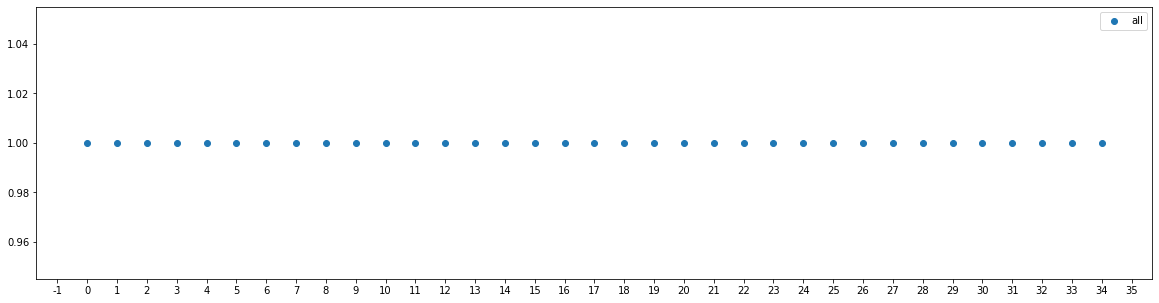

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	35 Nodes:
	[(4, 1), (9, 1), (10, 1), (11, 1), (18, 1), (29, 1), (35, 1), (41, 1), (46, 1), (55, 1), (56, 1), (84, 1), (87, 1), (132, 1), (142, 1), (153, 1), (163, 1), (165, 1), (167, 1), (168, 1), (179, 1), (211, 1), (218, 1), (221, 1), (227, 1), (231, 1), (247, 1), (254, 1), (263, 1), (269, 1), (279, 1), (290, 1), (301, 1), (313, 1), (355, 1)]


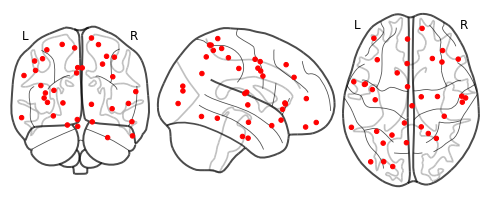

In [32]:
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes_sfsLR.most_common(50)]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes_sfsLR)), step=1))
plt.legend(['all','6'])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes_sfsLR=counter_nodes_sfsLR.most_common(50)
nd_sfsLR = [a[0] for a in fNodes_sfsLR]
ns_sfsLR = [a[1] for a in fNodes_sfsLR]
viz.brain_viz_nodes(nodes=nd_sfsLR,
                    title=
                    "\t%d Nodes:\n\t%s"%(len(nd_sfsLR),
                                         counter_nodes_sfsLR.most_common(360)),
                    method='2d',node_size = ns_sfsLR)

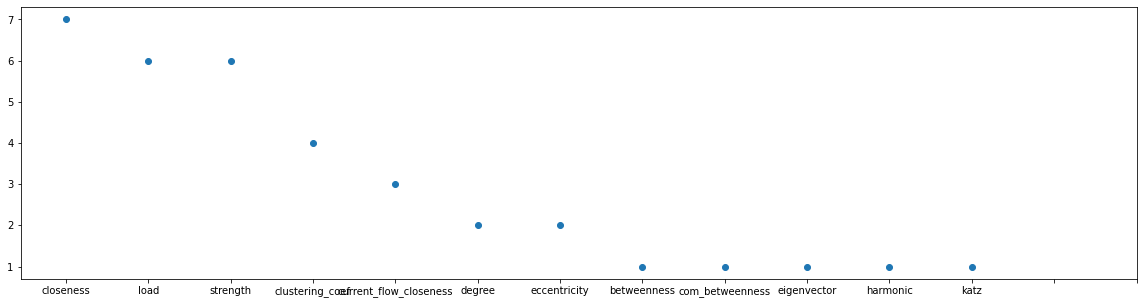

[('closeness', 7), ('load', 6), ('strength', 6), ('clustering_coef', 4), ('current_flow_closeness', 3), ('degree', 2), ('eccentricity', 2), ('betweenness', 1), ('com_betweenness', 1), ('eigenvector', 1), ('harmonic', 1), ('katz', 1)]


In [33]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures_sfsLR.most_common(50)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()
print(counter_measures_sfsLR.most_common(14))

Selecting effective nodes and measures based on FSF algorithm (linear regression classifier)

#### SVM

In [34]:
svc = svm.SVC(random_state=0, probability=True)
sfsSVC = SFS(svc, 
           k_features=17,
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

In [35]:
sfsSVC.fit(fisher_features_np, labels_np,tuple(fisher_features.columns))
sfsSVC.k_feature_names_ 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2518 out of 2518 | elapsed:    9.9s finished

[2020-10-02 20:11:21] Features: 1/17 -- score: 0.5104166666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2517 out of 2517 | elapsed:   10.0s finished

[2020-10-02 20:11:32] Features: 2/17 -- score: 0.6354166666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 2516 out of 2516 | elapsed:    9.5s finished

[2020-10-02 20:11:41] Features: 3/17 -- score: 0.6979166666666666[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: 

((165, 'closeness'),
 (92, 'clustering_coef'),
 (69, 'harmonic'),
 (355, 'clustering_coef'),
 (71, 'harmonic'),
 (270, 'clustering_coef'),
 (33, 'clustering_coef'),
 (314, 'harmonic'),
 (224, 'subgraph'),
 (110, 'degree'),
 (335, 'strength'),
 (300, 'harmonic'),
 (32, 'clustering_coef'),
 (276, 'katz'),
 (157, 'degree'),
 (66, 'pagerank'),
 (267, 'clustering_coef'))

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


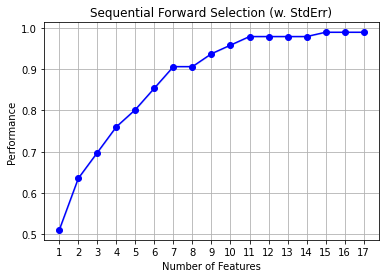

In [36]:
figSVC = plot_sfs(sfsSVC.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [37]:
sfsSVC.subsets_

{1: {'feature_idx': (54,),
  'cv_scores': array([0.51041667]),
  'avg_score': 0.5104166666666666,
  'feature_names': ((92, 'clustering_coef'),)},
 2: {'feature_idx': (54, 542),
  'cv_scores': array([0.63541667]),
  'avg_score': 0.6354166666666666,
  'feature_names': ((92, 'clustering_coef'), (224, 'subgraph'))},
 3: {'feature_idx': (54, 542, 1321),
  'cv_scores': array([0.69791667]),
  'avg_score': 0.6979166666666666,
  'feature_names': ((92, 'clustering_coef'),
   (224, 'subgraph'),
   (276, 'katz'))},
 4: {'feature_idx': (54, 542, 1321, 1341),
  'cv_scores': array([0.76041667]),
  'avg_score': 0.7604166666666666,
  'feature_names': ((92, 'clustering_coef'),
   (224, 'subgraph'),
   (276, 'katz'),
   (157, 'degree'))},
 5: {'feature_idx': (54, 542, 763, 1321, 1341),
  'cv_scores': array([0.80208333]),
  'avg_score': 0.8020833333333334,
  'feature_names': ((92, 'clustering_coef'),
   (224, 'subgraph'),
   (300, 'harmonic'),
   (276, 'katz'),
   (157, 'degree'))},
 6: {'feature_idx': (5

In [38]:
fisher_features_names_sfsSVM = list(sfsSVC.k_feature_names_)
fisher_features_names_sfsSVM = [ffn for ffn in fisher_features_names_sfsSVM if type(ffn)!=str]
fisher_features_nodes_sfsSVM = [ffn[0] for ffn in fisher_features_names_sfsSVM]
fisher_features_measures_sfsSVM = [ffn[1] for ffn in fisher_features_names_sfsSVM]
fisher_features_measures_sfsSVM.sort()
fisher_features_nodes_sfsSVM.sort()
counter_measures_sfsSVM=collections.Counter(fisher_features_measures_sfsSVM)
counter_nodes_sfsSVM=collections.Counter(fisher_features_nodes_sfsSVM)

In [39]:
enodes_sfsSVM = [np.array(counter_nodes_sfsSVM.most_common(360)),
                'sfsSVM-%d'%len(counter_nodes_sfsSVM.most_common(360))]

<Figure size 1440x360 with 0 Axes>

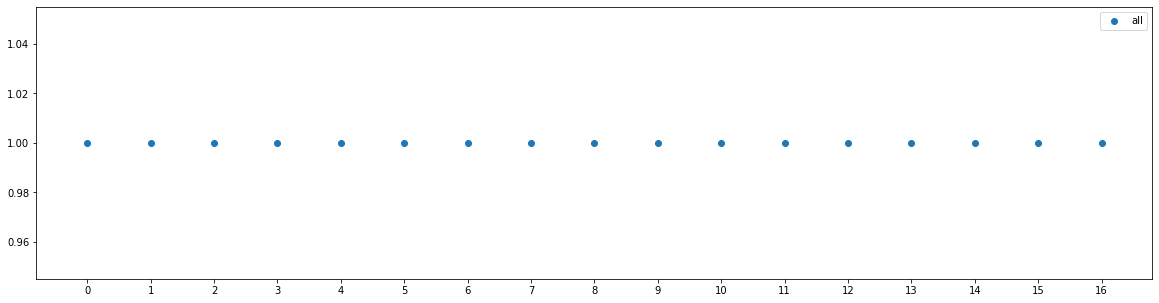

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	17 Nodes:
	[(32, 1), (33, 1), (66, 1), (69, 1), (71, 1), (92, 1), (110, 1), (157, 1), (165, 1), (224, 1), (267, 1), (270, 1), (276, 1), (300, 1), (314, 1), (335, 1), (355, 1)]


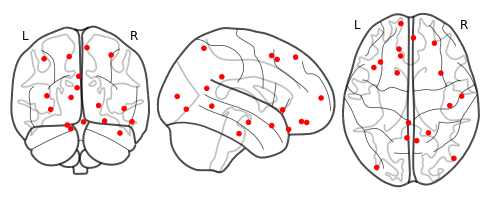

In [40]:
plt.figure(figsize=(20,5))
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes_sfsSVM.most_common(50)]))
plt.xticks(np.arange(0, len(set(fisher_features_nodes_sfsSVM)), step=1))
plt.legend(['all','6'])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes_sfsSVM=counter_nodes_sfsSVM.most_common(50)
nd_sfsSVM = [a[0] for a in fNodes_sfsSVM]
ns_sfsSVM = [a[1] for a in fNodes_sfsSVM]
viz.brain_viz_nodes(nodes=nd_sfsSVM,
                    title="\t%d Nodes:\n\t%s"
                    %(len(nd_sfsSVM),counter_nodes_sfsSVM.most_common(360)), 
                      method='2d',node_size = ns_sfsSVM)

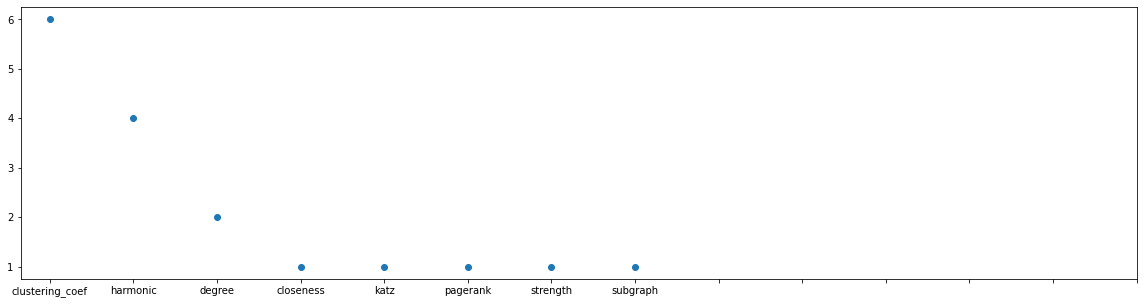

[('clustering_coef', 6), ('harmonic', 4), ('degree', 2), ('closeness', 1), ('katz', 1), ('pagerank', 1), ('strength', 1), ('subgraph', 1)]


In [41]:
plt.figure(figsize=(20,5))
plt.scatter(*zip(*counter_measures_sfsSVM.most_common(50)))
plt.xticks(np.arange(0, 14, step=1))
plt.show()
print(counter_measures_sfsSVM.most_common(14))

### Link Selection Based on Correlation Matrices

In [42]:
cols = subjects_list[subjects_groups[0]].copy()
sep=[len(subjects_list[subjects_groups[0]])]
for i in range(1,len(subjects_groups)):
    cols.extend(subjects_list[subjects_groups[i]])
    sep.append(len(subjects_list[subjects_groups[i]]) + sep[i-1])
sep.insert(0,0)

In [43]:
dfM = {}
for i in range(len(subjects_groups)):
    for s in cols[sep[i]:sep[i+1]]:
        if ct == 'glasso':
            if sign=='both':
                filesnp = glob.glob(rootdir + "/data/04_correlations/corr-%s/all/ds-%s/*%s*.npy"
                                    %(ct,ds,s))
            M  = np.load(filesnp[0])
        else:
            M = gla.read_M(s,ds,ct)
        df = pd.DataFrame(data=M, index=range(np.shape(M)[0]), columns=range(np.shape(M)[0]))
        df = df.drop([119],axis=1)
        df = df.drop([119],axis=0)
        df = df.stack().to_frame()
        try:
            dfM[subjects_groups[i]] = pd.concat([dfM[subjects_groups[i]],df],axis=1)
        except KeyError:
            dfM[subjects_groups[i]] = df.copy()
    try:
        dfM['all'] = pd.concat([dfM['all'],dfM[subjects_groups[i]]],axis=1)
    except KeyError:
        dfM['all'] = dfM[subjects_groups[i]].copy()

#### Fisher

In [44]:
score = fisher_score.fisher_score(dfM['all'].T.values, labels_np)
idx   = fisher_score.feature_ranking(score)

In [45]:
fisher_features260       = dfM['all'].T.iloc[:, idx[:520]]
fisher_features_names260 = list(fisher_features260.T.index) 
fisher_features_1260     = [ffn[0] for ffn in fisher_features_names260]
fisher_features_nodes260 = [ffn[1] for ffn in fisher_features_names260]
fisher_features_nodes260.extend(fisher_features_1260)
fisher_features_nodes260.sort()
counter_nodes260=collections.Counter(fisher_features_nodes260)

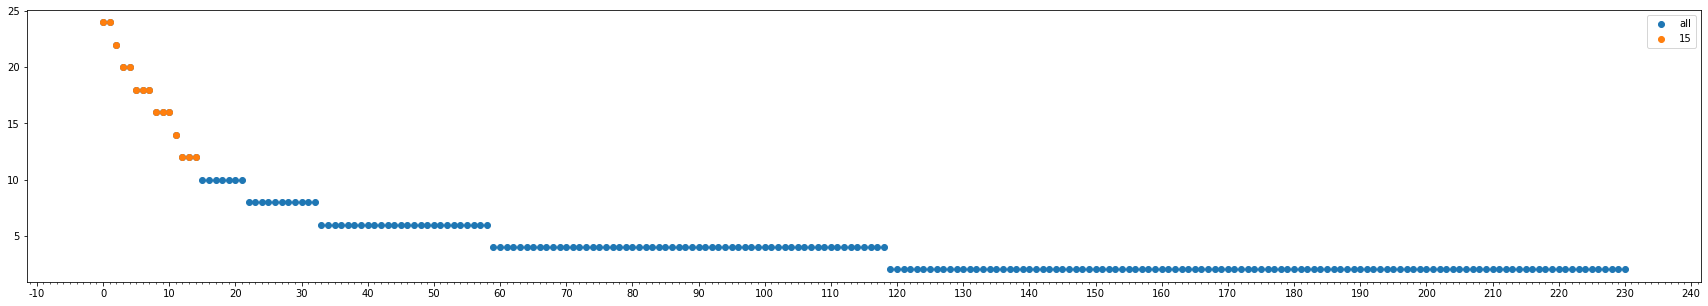

/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/alireza/Thesis/THSenv/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


	15 Links:
	[(264, 24), (338, 24), (348, 22), (156, 20), (272, 20), (140, 18), (254, 18), (290, 18), (134, 16), (168, 16), (252, 16), (225, 14), (142, 12), (258, 12), (337, 12)]


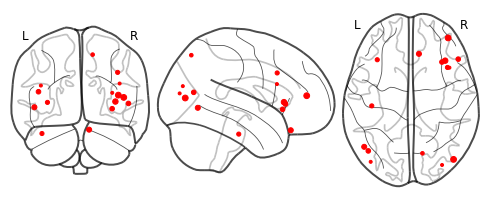

In [46]:
a2 = 15
fig, ax = plt.subplots(figsize=(30,5))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes260.most_common(len(set(fisher_features_nodes260)))]))
plt.scatter(*zip(*[(str(a[0]),a[1]) for a in counter_nodes260.most_common(a2)]))

plt.xticks(np.arange(0, len(set(fisher_features_nodes260)), step=1))
plt.legend(['all',a2])
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.show()

fNodes2602=counter_nodes260.most_common(a2)
nd2602 = [a[0] for a in fNodes2602]
ns2602 = [a[1] for a in fNodes2602]
viz.brain_viz_nodes(nodes=nd2602,title="\t%s Links:\n\t%s"%(a2,counter_nodes260.most_common(a2)),method='2d',node_size = ns2602)
plt.show()

In [47]:
fisher_features_links200 = dfM['all'].T.iloc[:, idx[:200]]
fisher_features_names_links200 = list(fisher_features_links200.T.index) 
fisher_features_names_links200

[(124, 65),
 (65, 124),
 (320, 140),
 (140, 320),
 (252, 338),
 (338, 252),
 (21, 156),
 (156, 21),
 (261, 264),
 (264, 261),
 (15, 283),
 (283, 15),
 (272, 314),
 (314, 272),
 (67, 252),
 (252, 67),
 (34, 300),
 (300, 34),
 (350, 290),
 (290, 350),
 (245, 292),
 (292, 245),
 (35, 225),
 (225, 35),
 (293, 134),
 (134, 293),
 (208, 338),
 (338, 208),
 (272, 219),
 (219, 272),
 (156, 269),
 (269, 156),
 (74, 2),
 (2, 74),
 (169, 348),
 (348, 169),
 (85, 17),
 (17, 85),
 (272, 77),
 (77, 272),
 (184, 140),
 (140, 184),
 (337, 250),
 (250, 337),
 (264, 83),
 (83, 264),
 (208, 150),
 (150, 208),
 (212, 318),
 (318, 212),
 (158, 152),
 (152, 158),
 (250, 47),
 (47, 250),
 (29, 89),
 (89, 29),
 (272, 355),
 (355, 272),
 (221, 290),
 (290, 221),
 (269, 336),
 (336, 269),
 (64, 254),
 (254, 64),
 (272, 356),
 (356, 272),
 (1, 142),
 (142, 1),
 (245, 290),
 (290, 245),
 (264, 169),
 (169, 264),
 (288, 278),
 (278, 288),
 (240, 348),
 (348, 240),
 (335, 157),
 (157, 335),
 (142, 319),
 (319, 142)

In [48]:
elinks_200 = [np.array(fisher_features_names_links200),
              'links-fisher-%d'
              %int(len(fisher_features_names_links200)/2)]

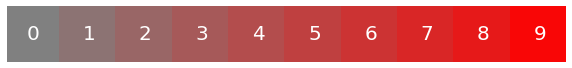

Link Selection Based on Correlation Matrices


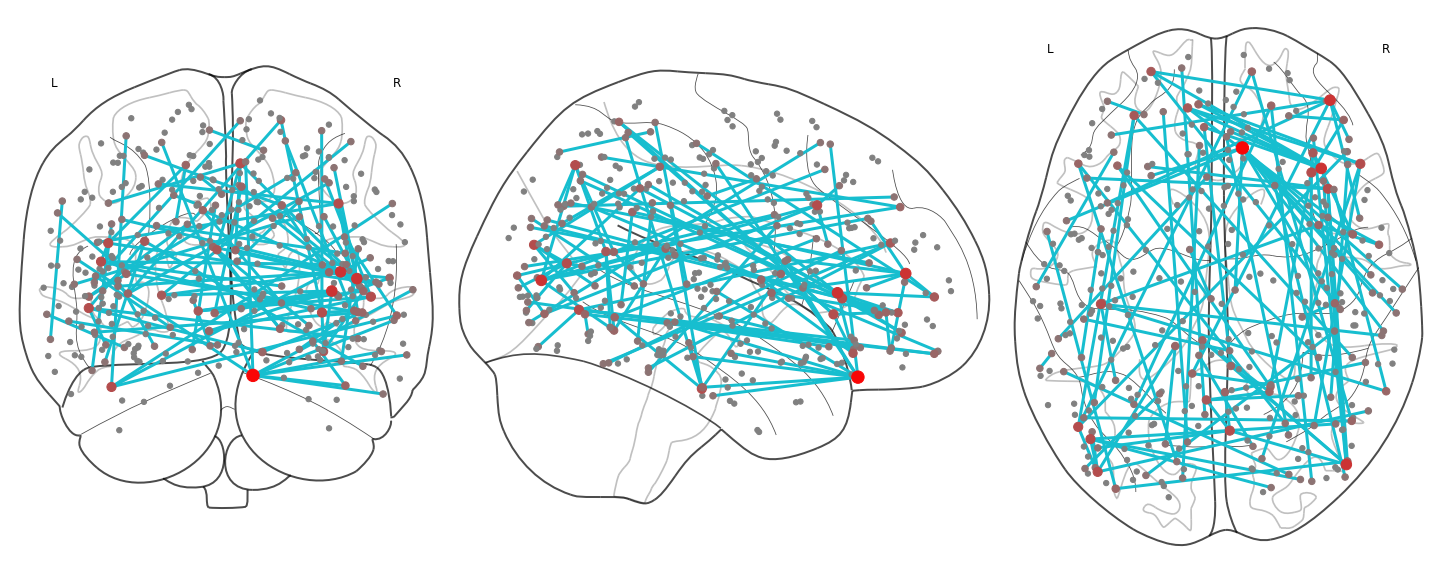

In [49]:
M = np.zeros((360,360))
for i in fisher_features_names_links200:
    M[i[0],i[1]]=1
viz.brain_viz_from_path(cm = M ,
                        title = 'Link Selection Based on Correlation Matrices',
                        density = 1, method = '2d')

#### PCA

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

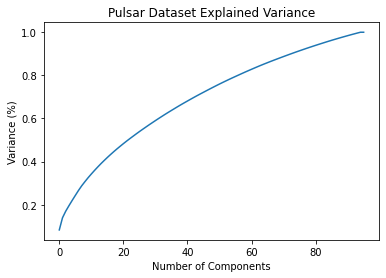

In [51]:
x = StandardScaler().fit_transform(dfM['all'].T)
pca = PCA().fit(x)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

### Save

In [52]:
os.system('mkdir -p %s/data/07_features/tm-%s/corr-%s/ds-%s'%(rootdir,tm,ct,ds))

np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes4_top[1],ds,ct,sgn,tm), enodes4_top[0])
        
np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes4[1],ds,ct,sgn,tm), enodes4[0])
        
np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes_sfsLR[1],ds,ct,sgn,tm), enodes_sfsLR[0])
        
np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,enodes_sfsSVM[1],ds,ct,sgn,tm), enodes_sfsSVM[0])

np.save("%s/data/07_features/tm-%s/corr-%s/ds-%s/method-%s_ds-%s_corr-%s-%s_tm-%s"
            %(rootdir,tm,ct,ds,elinks_200[1],ds,ct,sgn,tm), elinks_200[0])

#### Save the notebook

In [53]:
os.system("mkdir -p %s/docs/feature_selection"%(rootdir))

0

In [54]:
os.system("cp %s/notebooks/08_feature_selection-Copy1.ipynb %s/docs/feature_selection/%s-%s-corr_ds-%s_tm-%s.ipynb"
          %(rootdir,rootdir,ct,sgn,ds,tm))

0